ref
1) https://mathmatical22.xyz/2020/04/11/【初学者向け】lightgbm-基本的な使い方-多クラス分類編/
2) https://toukei-lab.com/light-gbm

# Import

In [1]:
import sys
%load_ext autoreload
%autoreload 2
sys.path.append('../')

In [2]:
import numpy as np
import pandas as pd
import warnings

import lightgbm as lgb
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier

from src import common

# Intro

In [65]:
DATA_DIR = Path('..', '..', '..', 'data', 'final', 'public')
train_values = pd.read_csv(DATA_DIR / 'train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv', index_col='building_id')

## preprocessing

In [67]:
train_values, train_labels = lgbm_preprocessing((train_values, train_labels), mode='training')

## split to train and test

In [68]:
X_train, X_test, y_train, y_test = train_test_split(train_values, train_labels, 
                                                    test_size=0.1, random_state=19, stratify=train_labels)

In [69]:
trains = lgb.Dataset(X_train, y_train)
valids = lgb.Dataset(X_test, y_test)

In [70]:
params = {
    "objective": "multiclass",
    "num_class": 3, 
    "metrics": "multi_logloss",
    'force_row_wise': True, 
    "learning_rate": 0.2
    
}

model = lgb.train(params, trains, valid_sets=valids, num_boost_round=1000, early_stopping_rounds=100)

[LightGBM] [Info] Total Bins 776
[LightGBM] [Info] Number of data points in the train set: 234540, number of used features: 37
[LightGBM] [Info] Start training from score -2.339190
[LightGBM] [Info] Start training from score -0.564027
[LightGBM] [Info] Start training from score -1.094578
[1]	valid_0's multi_logloss: 0.834899
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.79255
[3]	valid_0's multi_logloss: 0.764601
[4]	valid_0's multi_logloss: 0.745064
[5]	valid_0's multi_logloss: 0.730304
[6]	valid_0's multi_logloss: 0.71916
[7]	valid_0's multi_logloss: 0.710218


/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[8]	valid_0's multi_logloss: 0.703205
[9]	valid_0's multi_logloss: 0.69805
[10]	valid_0's multi_logloss: 0.693236
[11]	valid_0's multi_logloss: 0.689566
[12]	valid_0's multi_logloss: 0.686027
[13]	valid_0's multi_logloss: 0.682844
[14]	valid_0's multi_logloss: 0.680392
[15]	valid_0's multi_logloss: 0.677686
[16]	valid_0's multi_logloss: 0.675078
[17]	valid_0's multi_logloss: 0.672411
[18]	valid_0's multi_logloss: 0.670147
[19]	valid_0's multi_logloss: 0.668575
[20]	valid_0's multi_logloss: 0.666035
[21]	valid_0's multi_logloss: 0.664231
[22]	valid_0's multi_logloss: 0.662829
[23]	valid_0's multi_logloss: 0.661265
[24]	valid_0's multi_logloss: 0.659862
[25]	valid_0's multi_logloss: 0.658394
[26]	valid_0's multi_logloss: 0.657483
[27]	valid_0's multi_logloss: 0.656495
[28]	valid_0's multi_logloss: 0.655576
[29]	valid_0's multi_logloss: 0.654715
[30]	valid_0's multi_logloss: 0.653716
[31]	valid_0's multi_logloss: 0.652462
[32]	valid_0's multi_logloss: 0.650886
[33]	valid_0's multi_logloss

## predict

In [71]:
# テストデータの予測 ((各クラスの予測確率 [クラス0の予測確率,クラス1の予測確率,クラス2の予測確率] を返す))
y_pred_prob = model.predict(X_test)
# テストデータの予測 (予測クラス(0 or 1 or 2)を返す)
y_pred = np.argmax(y_pred_prob, axis=1) # 一番大きい予測確率のクラスを予測クラスに
# 真値と予測値の表示
df_pred = pd.DataFrame({'target':y_test['damage_grade'].values,'target_pred':y_pred})
display(df_pred)

# 真値と予測確率の表示
df_pred_prob = pd.DataFrame({'y':y_test['damage_grade'].values, 'target0_prob':y_pred_prob[:,0], 'target1_prob':y_pred_prob[:,1], 'target2_prob':y_pred_prob[:,2]})
display(df_pred_prob)

acc = accuracy_score(y_test,y_pred)
print('Acc :', acc)

,target,target_pred
0,1,1
1,2,1
2,1,2
3,1,1
4,1,1
...,...,...
26056,0,0
26057,1,1
26058,1,1
26059,0,1


,y,target0_prob,target1_prob,target2_prob
0,1,0.018569,0.821047,0.160384
1,2,0.002044,0.523914,0.474042
2,1,0.000164,0.373575,0.626261
3,1,0.005715,0.896519,0.097767
4,1,0.253461,0.686330,0.060210
...,...,...,...,...
26056,0,0.501258,0.456957,0.041785
26057,1,0.148519,0.678045,0.173436
26058,1,0.341064,0.602124,0.056812
26059,0,0.255593,0.712903,0.031504


Acc : 0.7444457234948774


## Submit

In [72]:
test_values = pd.read_csv(DATA_DIR / 'test_values.csv', index_col='building_id')
test_values, _ = lgbm_preprocessing(test_values, mode='test')

In [74]:
y_test_prob = model.predict(test_values)

In [76]:
y_test = np.argmax(y_test_prob, axis=1)

In [80]:
submission_format = pd.read_csv(DATA_DIR / 'submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=y_test+1,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [84]:
my_submission.to_csv('../../../data/final/submit/submission_lgbm_first.csv')

# Use only high importance features

High importance columns in CatBoost

ref: https://github.com/pat42w/Richters_predictor/blob/master/Richter_entry_v1.ipynb

In [ ]:
DATA_DIR = Path('..', '..', '..', 'data', 'final', 'public')
train_values = pd.read_csv(DATA_DIR / 'train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv', index_col='building_id')

In [5]:
features_list = ['geo_level_1_id', 
                 'geo_level_2_id', 
                 'geo_level_3_id',
                 'age', 
                 'area_percentage', 
                 'height_percentage', 
                 'foundation_type', 
                 'roof_type', 
                 'ground_floor_type', 
                 'other_floor_type', 
                 'position', 
                 'has_superstructure_mud_mortar_stone', 
                 'has_superstructure_cement_mortar_brick', 
                 'has_superstructure_timber', 
                 'count_families', 
                 'has_secondary_use'
                ]

## preprocessing

In [100]:
train_values, train_labels = lgbm_preprocessing((train_values, train_labels), mode='training', features_list=features_list)

/var/folders/qj/_yh_g9w9493323w1yhldjhkh0000gn/T/ipykernel_17571/3783818178.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  values[_col] = values[_col].astype("category")
/var/folders/qj/_yh_g9w9493323w1yhldjhkh0000gn/T/ipykernel_17571/3783818178.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  values[_col] = values[_col].astype("category")
/var/folders/qj/_yh_g9w9493323w1yhldjhkh0000gn/T/ipykernel_17571/3783818178.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

## split to train and test

In [98]:
X_train, X_test, y_train, y_test = train_test_split(train_values, train_labels, 
                                                    test_size=0.1, random_state=19, stratify=train_labels)

In [ ]:
trains = lgb.Dataset(X_train, y_train)
valids = lgb.Dataset(X_test, y_test)

In [9]:
params = {
    "objective": "multiclass",
    "num_class": 3, 
    "metrics": "multi_logloss",
    'force_row_wise': True, 
    "learning_rate": 0.15, 
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    
}

model = lgb.train(params, trains, valid_sets=valids, num_boost_round=2000, early_stopping_rounds=100)

[LightGBM] [Info] Total Bins 776
[LightGBM] [Info] Number of data points in the train set: 234540, number of used features: 37
[LightGBM] [Info] Start training from score -2.339190
[LightGBM] [Info] Start training from score -0.564027
[LightGBM] [Info] Start training from score -1.094578
[1]	valid_0's multi_logloss: 0.852582
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.814486
[3]	valid_0's multi_logloss: 0.787538
[4]	valid_0's multi_logloss: 0.767029
[5]	valid_0's multi_logloss: 0.751161
[6]	valid_0's multi_logloss: 0.739066


/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[7]	valid_0's multi_logloss: 0.729024
[8]	valid_0's multi_logloss: 0.720855
[9]	valid_0's multi_logloss: 0.713498
[10]	valid_0's multi_logloss: 0.708343
[11]	valid_0's multi_logloss: 0.702942
[12]	valid_0's multi_logloss: 0.699085
[13]	valid_0's multi_logloss: 0.695438
[14]	valid_0's multi_logloss: 0.692397
[15]	valid_0's multi_logloss: 0.689568
[16]	valid_0's multi_logloss: 0.686693
[17]	valid_0's multi_logloss: 0.684426
[18]	valid_0's multi_logloss: 0.682505
[19]	valid_0's multi_logloss: 0.680491
[20]	valid_0's multi_logloss: 0.678756
[21]	valid_0's multi_logloss: 0.676522
[22]	valid_0's multi_logloss: 0.674871
[23]	valid_0's multi_logloss: 0.67356
[24]	valid_0's multi_logloss: 0.672147
[25]	valid_0's multi_logloss: 0.67095
[26]	valid_0's multi_logloss: 0.669106
[27]	valid_0's multi_logloss: 0.667871
[28]	valid_0's multi_logloss: 0.666626
[29]	valid_0's multi_logloss: 0.665366
[30]	valid_0's multi_logloss: 0.663725
[31]	valid_0's multi_logloss: 0.66251
[32]	valid_0's multi_logloss: 0

## predict

In [10]:
# テストデータの予測 ((各クラスの予測確率 [クラス0の予測確率,クラス1の予測確率,クラス2の予測確率] を返す))
y_pred_prob = model.predict(X_test)
# テストデータの予測 (予測クラス(0 or 1 or 2)を返す)
y_pred = np.argmax(y_pred_prob, axis=1) # 一番大きい予測確率のクラスを予測クラスに
# 真値と予測値の表示
df_pred = pd.DataFrame({'target':y_test['damage_grade'].values,'target_pred':y_pred})
display(df_pred)

# 真値と予測確率の表示
df_pred_prob = pd.DataFrame({'y':y_test['damage_grade'].values, 'target0_prob':y_pred_prob[:,0], 'target1_prob':y_pred_prob[:,1], 'target2_prob':y_pred_prob[:,2]})
display(df_pred_prob)

acc = accuracy_score(y_test,y_pred)
print('Acc :', acc)

,target,target_pred
0,1,1
1,2,2
2,1,2
3,1,1
4,1,1
...,...,...
26056,0,0
26057,1,1
26058,1,1
26059,0,1


,y,target0_prob,target1_prob,target2_prob
0,1,0.030709,0.638411,0.330880
1,2,0.001730,0.472421,0.525849
2,1,0.000252,0.431001,0.568747
3,1,0.000938,0.903759,0.095302
4,1,0.254144,0.711050,0.034806
...,...,...,...,...
26056,0,0.481308,0.461495,0.057197
26057,1,0.295955,0.558076,0.145969
26058,1,0.328103,0.625668,0.046229
26059,0,0.176912,0.795127,0.027962


Acc : 0.7487049614366295


## Submit

In [11]:
test_values = pd.read_csv(DATA_DIR / 'test_values.csv', index_col='building_id')
test_values, _ = lgbm_preprocessing(test_values, mode='test')

In [12]:
y_test_prob = model.predict(test_values)

In [13]:
y_test = np.argmax(y_test_prob, axis=1)

In [14]:
submission_format = pd.read_csv(DATA_DIR / 'submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=y_test+1,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [15]:
my_submission.to_csv('../../../data/final/submit/lgbm_mod_param.csv')

# create of new features

In [24]:
DATA_DIR = Path('..', '..', '..', 'data', 'final', 'public')
train_values = pd.read_csv(DATA_DIR / 'train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv', index_col='building_id')

Now top score parameter

Acc: 0.7195042400521853

In [18]:
features_list = ['geo_level_1_id', 
                 'geo_level_2_id', 
                 'geo_level_3_id',
                 'age', 
                 'area_percentage', 
                 'height_percentage', 
                 'foundation_type', 
                 'roof_type', 
                 'ground_floor_type', 
                 'other_floor_type', 
                 'position', 
                 'has_superstructure_mud_mortar_stone', 
                 'has_superstructure_cement_mortar_brick', 
                 'has_superstructure_timber', 
                 'count_families', 
                 'has_secondary_use'
                ]

# preprocessing

train_values, train_labels = lgbm_preprocessing((train_values, train_labels), mode='training', features_list=features_list)

# split to train and test

X_train, X_test, y_train, y_test = train_test_split(train_values, train_labels, 
                                                    test_size=0.1, random_state=19, stratify=train_labels)

trains = lgb.Dataset(X_train, y_train)
valids = lgb.Dataset(X_test, y_test)

params = {
    "objective": "multiclass",
    "num_class": 3, 
    "metrics": "multi_logloss",
    'force_row_wise': True, 
    "learning_rate": 0.15, 
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    
}

model = lgb.train(params, trains, valid_sets=valids, num_boost_round=100, early_stopping_rounds=10)

# predict

# テストデータの予測 ((各クラスの予測確率 [クラス0の予測確率,クラス1の予測確率,クラス2の予測確率] を返す))
y_pred_prob = model.predict(X_test)
# テストデータの予測 (予測クラス(0 or 1 or 2)を返す)
y_pred = np.argmax(y_pred_prob, axis=1) # 一番大きい予測確率のクラスを予測クラスに
# 真値と予測値の表示
df_pred = pd.DataFrame({'target':y_test['damage_grade'].values,'target_pred':y_pred})
display(df_pred)

# 真値と予測確率の表示
df_pred_prob = pd.DataFrame({'y':y_test['damage_grade'].values, 'target0_prob':y_pred_prob[:,0], 'target1_prob':y_pred_prob[:,1], 'target2_prob':y_pred_prob[:,2]})
display(df_pred_prob)

acc = accuracy_score(y_test,y_pred)
print('Acc :', acc)

[LightGBM] [Info] Total Bins 776
[LightGBM] [Info] Number of data points in the train set: 234540, number of used features: 37
[LightGBM] [Info] Start training from score -2.339190
[LightGBM] [Info] Start training from score -0.564027
[LightGBM] [Info] Start training from score -1.094578
[1]	valid_0's multi_logloss: 0.852582
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.814486
[3]	valid_0's multi_logloss: 0.787538
[4]	valid_0's multi_logloss: 0.767029
[5]	valid_0's multi_logloss: 0.751161
[6]	valid_0's multi_logloss: 0.739066


/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[7]	valid_0's multi_logloss: 0.729024
[8]	valid_0's multi_logloss: 0.720855
[9]	valid_0's multi_logloss: 0.713498
[10]	valid_0's multi_logloss: 0.708343
[11]	valid_0's multi_logloss: 0.702942
[12]	valid_0's multi_logloss: 0.699085
[13]	valid_0's multi_logloss: 0.695438
[14]	valid_0's multi_logloss: 0.692397
[15]	valid_0's multi_logloss: 0.689568
[16]	valid_0's multi_logloss: 0.686693
[17]	valid_0's multi_logloss: 0.684426
[18]	valid_0's multi_logloss: 0.682505
[19]	valid_0's multi_logloss: 0.680491
[20]	valid_0's multi_logloss: 0.678756
[21]	valid_0's multi_logloss: 0.676522
[22]	valid_0's multi_logloss: 0.674871
[23]	valid_0's multi_logloss: 0.67356
[24]	valid_0's multi_logloss: 0.672147
[25]	valid_0's multi_logloss: 0.67095
[26]	valid_0's multi_logloss: 0.669106
[27]	valid_0's multi_logloss: 0.667871
[28]	valid_0's multi_logloss: 0.666626
[29]	valid_0's multi_logloss: 0.665366
[30]	valid_0's multi_logloss: 0.663725
[31]	valid_0's multi_logloss: 0.66251
[32]	valid_0's multi_logloss: 0

,target,target_pred
0,1,1
1,2,1
2,1,2
3,1,1
4,1,1
...,...,...
26056,0,1
26057,1,1
26058,1,0
26059,0,1


,y,target0_prob,target1_prob,target2_prob
0,1,0.142278,0.703710,0.154012
1,2,0.005029,0.522108,0.472864
2,1,0.002773,0.392505,0.604722
3,1,0.003112,0.714371,0.282517
4,1,0.260287,0.644762,0.094952
...,...,...,...,...
26056,0,0.321985,0.556077,0.121938
26057,1,0.170686,0.451352,0.377962
26058,1,0.493131,0.461045,0.045824
26059,0,0.199615,0.756685,0.043701


Acc : 0.7195042400521853


## Idea: combine some objects

In [92]:
DATA_DIR = Path('..', '..', '..', 'data', 'final', 'public')
train_values = pd.read_csv(DATA_DIR / 'train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv', index_col='building_id')

create new features

In [93]:
train_values['some_type'] = train_values['foundation_type'] + train_values['roof_type'] + train_values['ground_floor_type'] + train_values['other_floor_type']
train_values.drop(columns=['foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type'], inplace=True)

train_values['height_times_area'] = train_values['height_percentage'] + train_values['area_percentage']
train_values.drop(columns=['height_percentage', 'area_percentage'], inplace=True)

train_values['rc_en_non_en'] = train_values['has_superstructure_rc_engineered'].replace([0, 1], ['F', 'T']) + train_values['has_superstructure_rc_non_engineered'].replace([0, 1], ['F', 'T'])

drop some features

In [ ]:
features_list = ['geo_level_1_id', 
                 'geo_level_2_id', 
                 'geo_level_3_id',
                 'age', 
                 # 'area_percentage', 
                 # 'height_percentage', 
                 # 'foundation_type', 
                 # 'roof_type', 
                 #'ground_floor_type', 
                 # 'other_floor_type', 
                 'position', 
                 'has_superstructure_mud_mortar_stone', 
                 'has_superstructure_cement_mortar_brick', 
                 'has_superstructure_timber', 
                 'count_families', 
                 'has_secondary_use', 
                 'some_type', 
                 'height_times_area', 
                 'rc_en_non_en'
                ]
train_values = train_values[features_list]

In [96]:
from sklearn.metrics import f1_score

print("Resample the train test split & try these parameters set")
X = train_values; y = train_labels
cat_cols = list(X.select_dtypes(include='object').columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

#input best params here from randm.best_params_
model = CatBoostClassifier(eval_metric='TotalF1',random_seed=42, cat_features=cat_cols, num_boost_round=100)
model.fit(X_train, y_train)
preds=model.predict(X_test)

#f1 score is the metric used in the competition
accuracy=f1_score(y_test,preds,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy)
print('\n Benchmark model was: 0.5815')

Resample the train test split & try these parameters set


/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Learning rate set to 0.5
0:	learn: 0.5718546	total: 84.4ms	remaining: 8.36s
1:	learn: 0.5770149	total: 174ms	remaining: 8.51s
2:	learn: 0.5936192	total: 252ms	remaining: 8.14s
3:	learn: 0.6087412	total: 328ms	remaining: 7.86s
4:	learn: 0.6281068	total: 404ms	remaining: 7.68s
5:	learn: 0.6414456	total: 476ms	remaining: 7.46s
6:	learn: 0.6430185	total: 560ms	remaining: 7.44s
7:	learn: 0.6447710	total: 639ms	remaining: 7.34s
8:	learn: 0.6483070	total: 716ms	remaining: 7.24s
9:	learn: 0.6513421	total: 796ms	remaining: 7.17s
10:	learn: 0.6523473	total: 876ms	remaining: 7.09s
11:	learn: 0.6553704	total: 961ms	remaining: 7.04s
12:	learn: 0.6572732	total: 1.03s	remaining: 6.92s
13:	learn: 0.6597517	total: 1.11s	remaining: 6.85s
14:	learn: 0.6619294	total: 1.19s	remaining: 6.73s
15:	learn: 0.6626886	total: 1.26s	remaining: 6.61s
16:	learn: 0.6629265	total: 1.32s	remaining: 6.47s
17:	learn: 0.6639005	total: 1.39s	remaining: 6.31s
18:	learn: 0.6636500	total: 1.46s	remaining: 6.21s
19:	learn: 0.66

<AxesSubplot: >

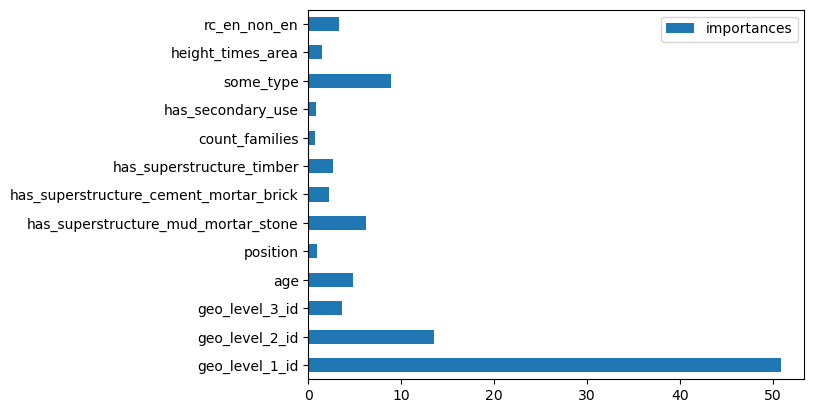

In [97]:
#get feature importances and graph, could look further into thesee to improve the model further
df_importances=pd.DataFrame(model.feature_importances_)
df_importances.index=train_values.columns
df_importances.columns=['importances']
df_importances.plot.barh()

In [87]:
train_values['has_superstructure_rc_engineered'].replace([0, 1], ['F', 'T']) + train_values['has_superstructure_rc_engineered'].replace([0, 1], ['F', 'T'])

building_id
802906    FF
28830     FF
94947     FF
590882    FF
201944    FF
          ..
688636    FF
669485    FF
602512    FF
151409    FF
747594    FF
Name: has_superstructure_rc_engineered, Length: 260601, dtype: object

## act to lgbm

In [105]:
def new_features(df):
    df['some_type'] = df['foundation_type'] + df['roof_type'] + df['ground_floor_type'] + df['other_floor_type']
    df.drop(columns=['foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type'], inplace=True)

    df['height_times_area'] = df['height_percentage'] + df['area_percentage']
    df.drop(columns=['height_percentage', 'area_percentage'], inplace=True)

    df['rc_en_non_en'] = df['has_superstructure_rc_engineered'].replace([0, 1], ['F', 'T']) + df['has_superstructure_rc_non_engineered'].replace([0, 1], ['F', 'T'])
    
    return df

In [107]:
features_list = ['geo_level_1_id', 
                 'geo_level_2_id', 
                 'geo_level_3_id',
                 'age', 
                 # 'area_percentage', 
                 # 'height_percentage', 
                 # 'foundation_type', 
                 # 'roof_type', 
                 #'ground_floor_type', 
                 # 'other_floor_type', 
                 'position', 
                 'has_superstructure_mud_mortar_stone', 
                 'has_superstructure_cement_mortar_brick', 
                 'has_superstructure_timber', 
                 'count_families', 
                 'has_secondary_use', 
                 'some_type', 
                 'height_times_area', 
                 'rc_en_non_en'
                ]

In [112]:
DATA_DIR = Path('..', '..', '..', 'data', 'final', 'public')
train_values = pd.read_csv(DATA_DIR / 'train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv', index_col='building_id')

create new features

In [114]:
train_values = new_features(train_values)

In [115]:
# preprocessing

train_values, train_labels = lgbm_preprocessing((train_values, train_labels), mode='training', features_list=features_list)

# split to train and test

X_train, X_test, y_train, y_test = train_test_split(train_values, train_labels, 
                                                    test_size=0.1, random_state=19, stratify=train_labels)

trains = lgb.Dataset(X_train, y_train)
valids = lgb.Dataset(X_test, y_test)

params = {
    "objective": "multiclass",
    "num_class": 3, 
    "metrics": "multi_logloss",
    'force_row_wise': True, 
    "learning_rate": 0.15, 
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    
}

model = lgb.train(params, trains, valid_sets=valids, num_boost_round=2000, early_stopping_rounds=100)

# predict

# テストデータの予測 ((各クラスの予測確率 [クラス0の予測確率,クラス1の予測確率,クラス2の予測確率] を返す))
y_pred_prob = model.predict(X_test)
# テストデータの予測 (予測クラス(0 or 1 or 2)を返す)
y_pred = np.argmax(y_pred_prob, axis=1) # 一番大きい予測確率のクラスを予測クラスに
# 真値と予測値の表示
df_pred = pd.DataFrame({'target':y_test['damage_grade'].values,'target_pred':y_pred})
display(df_pred)

# 真値と予測確率の表示
df_pred_prob = pd.DataFrame({'y':y_test['damage_grade'].values, 'target0_prob':y_pred_prob[:,0], 'target1_prob':y_pred_prob[:,1], 'target2_prob':y_pred_prob[:,2]})
display(df_pred_prob)

acc = accuracy_score(y_test,y_pred)
print('Acc :', acc)

[LightGBM] [Info] Total Bins 928
[LightGBM] [Info] Number of data points in the train set: 234540, number of used features: 34
[LightGBM] [Info] Start training from score -2.339190
[LightGBM] [Info] Start training from score -0.564027
[LightGBM] [Info] Start training from score -1.094578
[1]	valid_0's multi_logloss: 0.851813
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.813661
[3]	valid_0's multi_logloss: 0.786318
[4]	valid_0's multi_logloss: 0.765664
[5]	valid_0's multi_logloss: 0.749176
[6]	valid_0's multi_logloss: 0.736874
[7]	valid_0's multi_logloss: 0.727314
[8]	valid_0's multi_logloss: 0.719303
[9]	valid_0's multi_logloss: 0.712408
[10]	valid_0's multi_logloss: 0.706907
[11]	valid_0's multi_logloss: 0.701996


/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[12]	valid_0's multi_logloss: 0.698405
[13]	valid_0's multi_logloss: 0.694754
[14]	valid_0's multi_logloss: 0.691977
[15]	valid_0's multi_logloss: 0.68924
[16]	valid_0's multi_logloss: 0.686735
[17]	valid_0's multi_logloss: 0.683999
[18]	valid_0's multi_logloss: 0.681854
[19]	valid_0's multi_logloss: 0.679958
[20]	valid_0's multi_logloss: 0.677997
[21]	valid_0's multi_logloss: 0.676384
[22]	valid_0's multi_logloss: 0.675023
[23]	valid_0's multi_logloss: 0.673225
[24]	valid_0's multi_logloss: 0.67183
[25]	valid_0's multi_logloss: 0.670084
[26]	valid_0's multi_logloss: 0.668784
[27]	valid_0's multi_logloss: 0.667873
[28]	valid_0's multi_logloss: 0.666608
[29]	valid_0's multi_logloss: 0.665293
[30]	valid_0's multi_logloss: 0.664219
[31]	valid_0's multi_logloss: 0.663377
[32]	valid_0's multi_logloss: 0.662168
[33]	valid_0's multi_logloss: 0.661328
[34]	valid_0's multi_logloss: 0.660513
[35]	valid_0's multi_logloss: 0.659898
[36]	valid_0's multi_logloss: 0.659022
[37]	valid_0's multi_loglos

,target,target_pred
0,1,1
1,2,1
2,1,2
3,1,1
4,1,1
...,...,...
26056,0,0
26057,1,2
26058,1,1
26059,0,1


,y,target0_prob,target1_prob,target2_prob
0,1,0.043384,0.844257,0.112359
1,2,0.012811,0.539643,0.447546
2,1,0.000466,0.354237,0.645297
3,1,0.001030,0.921019,0.077951
4,1,0.218761,0.640696,0.140543
...,...,...,...,...
26056,0,0.503091,0.450075,0.046834
26057,1,0.214766,0.328128,0.457106
26058,1,0.235400,0.727252,0.037349
26059,0,0.177521,0.771913,0.050566


Acc : 0.7400713710141591


In [119]:
test_values = pd.read_csv(DATA_DIR / 'test_values.csv', index_col='building_id')
test_values = new_features(test_values)
test_values, _ = lgbm_preprocessing(test_values, mode='test', features_list=features_list)

In [120]:
y_test_prob = model.predict(test_values)

In [121]:
y_test = np.argmax(y_test_prob, axis=1)

In [122]:
submission_format = pd.read_csv(DATA_DIR / 'submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=y_test+1,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [123]:
my_submission.to_csv('../../../data/final/submit/lgbm_add_new_features.csv')

# Custom metric
ref: https://qiita.com/ground0state/items/1b7cf1977426bd8f0f28

In [22]:
from sklearn.metrics import f1_score

def f1(y_true, y_pred):
    N_LABELS = 3  # ラベルの数
    y_pred_ = y_pred.reshape(N_LABELS, len(y_pred) // N_LABELS).argmax(axis=0)
    score = f1_score(y_true, y_pred_, average='micro')
    return 'f1', score, True

In [5]:
train_values, train_labels = common.file.read_data('train')

features_list = ['geo_level_1_id', 
                 'geo_level_2_id', 
                 'geo_level_3_id',
                 'age', 
                 'area_percentage', 
                 'height_percentage', 
                 'foundation_type', 
                 'roof_type', 
                 'ground_floor_type', 
                 'other_floor_type', 
                 'position', 
                 'has_superstructure_mud_mortar_stone', 
                 'has_superstructure_cement_mortar_brick', 
                 'has_superstructure_timber', 
                 'count_families', 
                 'has_secondary_use'
                ]


train_values, train_labals = common.lgbm_preprocessing((train_values, train_labels), features_list=features_list)

In [25]:
# split to train and test

X_train, X_test, y_train, y_test = train_test_split(train_values, train_labels, 
                                                    test_size=0.1, random_state=19, stratify=train_labels)

trains = lgb.Dataset(X_train, y_train)
valids = lgb.Dataset(X_test, y_test)

params = {
    "objective": "multiclass",
    "num_class": 3, 
    'force_row_wise': True, 
    "learning_rate": 0.15, 
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'metric': None, 
    'n_estimators': 1000, 
}

In [26]:
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train, y_train, 
        eval_set=[(X_test, y_test)], 
        early_stopping_rounds=100, 
        eval_metric=f1)

/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.forma

[1]	valid_0's multi_logloss: 0.852582	valid_0's f1: 0.568896
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.814486	valid_0's f1: 0.632976
[3]	valid_0's multi_logloss: 0.787538	valid_0's f1: 0.639653
[4]	valid_0's multi_logloss: 0.767029	valid_0's f1: 0.654848
[5]	valid_0's multi_logloss: 0.751161	valid_0's f1: 0.667933
[6]	valid_0's multi_logloss: 0.739066	valid_0's f1: 0.675108
[7]	valid_0's multi_logloss: 0.729024	valid_0's f1: 0.679483
[8]	valid_0's multi_logloss: 0.720855	valid_0's f1: 0.680596
[9]	valid_0's multi_logloss: 0.713498	valid_0's f1: 0.681632
[10]	valid_0's multi_logloss: 0.708343	valid_0's f1: 0.682898
[11]	valid_0's multi_logloss: 0.702942	valid_0's f1: 0.685392
[12]	valid_0's multi_logloss: 0.699085	valid_0's f1: 0.687656
[13]	valid_0's multi_logloss: 0.695438	valid_0's f1: 0.688116
[14]	valid_0's multi_logloss: 0.692397	valid_0's f1: 0.68873
[15]	valid_0's multi_logloss: 0.689568	valid_0's f1: 0.689421
[16]	valid_0's mul

LGBMClassifier(force_row_wise=True, learning_rate=0.15, metric=None,
               n_estimators=1000, num_class=3, objective='multiclass',
               reg_alpha=0.3, reg_lambda=0.3)

In [31]:
# テストデータの予測 ((各クラスの予測確率 [クラス0の予測確率,クラス1の予測確率,クラス2の予測確率] を返す))
y_pred = clf.predict(X_test)

acc = f1_score(y_test,y_pred, average='micro')
print('Acc :', acc)

Acc : 0.7452515252676413


# K-fold
method: Stratified Shuffle Split

ref: https://amateur-engineer-blog.com/kaggle-cv-template-lightgbm/

In [34]:
from sklearn.model_selection import StratifiedKFold
import pickle

In [3]:
train_values, train_labels = common.file.read_data('train')

In [4]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

In [5]:
train_values, train_labels = common.lgbm_preprocessing((train_values, train_labels), mode='train')

In [6]:
train_labels['damage_grade'].unique()

array([2, 1, 0])

In [7]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 32 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   geo_level_1_id                          260601 non-null  int64
 1   geo_level_2_id                          260601 non-null  int64
 2   geo_level_3_id                          260601 non-null  int64
 3   age                                     260601 non-null  int64
 4   area_percentage                         260601 non-null  int64
 5   height_percentage                       260601 non-null  int64
 6   has_superstructure_mud_mortar_stone     260601 non-null  int64
 7   has_superstructure_cement_mortar_brick  260601 non-null  int64
 8   has_superstructure_timber               260601 non-null  int64
 9   count_families                          260601 non-null  int64
 10  has_secondary_use                       260601 non-null  int64


In [27]:
X_train, X_test, y_train, y_test = common.split_datas(train_values, train_labels)

In [30]:
model = common.modeling_datas(X_train, X_test, y_train, y_test, 
                              n_estimators=1000, early_stopping=100)

/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Unknown parameter: verbose_eval
[1]	valid_0's multi_logloss: 0.852627	valid_0's f1: 0.568896
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.814919	valid_0's f1: 0.632478
[3]	valid_0's multi_logloss: 0.787776	valid_0's f1: 0.638962
[4]	valid_0's multi_logloss: 0.767395	valid_0's f1: 0.657496
[5]	valid_0's multi_logloss: 0.751793	valid_0's f1: 0.666168
[6]	valid_0's multi_logloss: 0.739296	valid_0's f1: 0.676375
[7]	valid_0's multi_logloss: 0.729485	valid_0's f1: 0.679137
[8]	valid_0's multi_logloss: 0.721067	valid_0's f1: 0.681171
[9]	valid_0's multi_logloss: 0.714084	valid_0's f1: 0.682322
[10]	valid_0's multi_logloss: 0.708381	valid_0's f1: 0.683665
[11]	valid_0's multi_logloss: 0.703703	valid_0's f1: 0.684548
[12]	valid_0's multi_logloss: 0.699699	valid_0's f1: 0.686044
[13]	valid_0's multi_logloss: 0.696325	valid_0's f1: 0.688001
[14]	valid_0's multi_logloss: 0.69342	valid_0's f1: 0.689306
[15]	valid_0's multi_loglos

In [19]:
common.predict_model(X_test, y_test, model)

       target  target_pred
0           1            1
1           2            2
2           1            2
3           1            1
4           1            1
...       ...          ...
26056       0            1
26057       1            1
26058       1            1
26059       0            1
26060       1            1

[26061 rows x 2 columns]
Acc : 0.7444073519818887
f1_score: 0.7444073519818887


shuffleSplit

In [33]:
valid_scores = list()
models = list()

# dataframe to ndarray
if type(X_train) == pd.DataFrame:
    X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

# k-fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=19)
for fold, (train_indices, valid_indices) in enumerate(kf.split(X_train, y_train)):
    
    # split k-fold train and valid
    kf_X_train, kf_X_valid = X_train[train_indices], X_train[valid_indices]
    kf_y_train, kf_y_valid = y_train[train_indices], y_train[valid_indices]
    
    # modeling and score
    model = common.modeling_datas(kf_X_train, kf_X_valid, kf_y_train, kf_y_valid, 
                                  n_estimators=1000, early_stopping=100)
    _, score = common.predict_model(X_test, y_test, model, return_score=True)
    valid_scores.append(score)
    
    file_path = f'../../../model/230228_lgbm/model_{fold}.pkl'
    pickle.dump(model, open(file_path, 'wb'))
print(f'CV score: {np.mean(valid_scores)}')

/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[1]	valid_0's multi_logloss: 0.851736	valid_0's f1: 0.568922
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.813096	valid_0's f1: 0.634199
[3]	valid_0's multi_logloss: 0.785691	valid_0's f1: 0.640232
[4]	valid_0's multi_logloss: 0.765263	valid_0's f1: 0.652149
[5]	valid_0's multi_logloss: 0.749008	valid_0's f1: 0.669033
[6]	valid_0's multi_logloss: 0.736362	valid_0's f1: 0.672657
[7]	valid_0's multi_logloss: 0.726179	valid_0's f1: 0.67739
[8]	valid_0's multi_logloss: 0.717798	valid_0's f1: 0.680289
[9]	valid_0's multi_logloss: 0.711153	valid_0's f1: 0.682336
[10]	valid_0's multi_logloss: 0.705787	valid_0's f1: 0.683657
[11]	valid_0's multi_logloss: 0.70056	valid_0's f1: 0.684958
[12]	valid_0's multi_logloss: 0.696552	valid_0's f1: 0.686749
[13]	valid_0's multi_logloss: 0.693274	valid_0's f1: 0.688241
[14]	valid_0's multi_logloss: 0.690427	valid_0's f1: 0.689307
[15]	valid_0's multi_logloss: 0.687714	valid_0's f1: 0.690351
[16]	valid_0's mult

/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[1]	valid_0's multi_logloss: 0.852319	valid_0's f1: 0.568922
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.814307	valid_0's f1: 0.629445
[3]	valid_0's multi_logloss: 0.787212	valid_0's f1: 0.635414
[4]	valid_0's multi_logloss: 0.76735	valid_0's f1: 0.654025
[5]	valid_0's multi_logloss: 0.751772	valid_0's f1: 0.661017
[6]	valid_0's multi_logloss: 0.73878	valid_0's f1: 0.673894
[7]	valid_0's multi_logloss: 0.729278	valid_0's f1: 0.679607
[8]	valid_0's multi_logloss: 0.721202	valid_0's f1: 0.681547
[9]	valid_0's multi_logloss: 0.713977	valid_0's f1: 0.682869
[10]	valid_0's multi_logloss: 0.708286	valid_0's f1: 0.685704
[11]	valid_0's multi_logloss: 0.703567	valid_0's f1: 0.68645
[12]	valid_0's multi_logloss: 0.700036	valid_0's f1: 0.687878
[13]	valid_0's multi_logloss: 0.69691	valid_0's f1: 0.688198
[14]	valid_0's multi_logloss: 0.694057	valid_0's f1: 0.689285
[15]	valid_0's multi_logloss: 0.691311	valid_0's f1: 0.689648
[16]	valid_0's multi_

/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[1]	valid_0's multi_logloss: 0.85291	valid_0's f1: 0.568922
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.815081	valid_0's f1: 0.626887
[3]	valid_0's multi_logloss: 0.788072	valid_0's f1: 0.637333
[4]	valid_0's multi_logloss: 0.768365	valid_0's f1: 0.651616
[5]	valid_0's multi_logloss: 0.752286	valid_0's f1: 0.663213
[6]	valid_0's multi_logloss: 0.740176	valid_0's f1: 0.670802
[7]	valid_0's multi_logloss: 0.730697	valid_0's f1: 0.673552
[8]	valid_0's multi_logloss: 0.722231	valid_0's f1: 0.675322
[9]	valid_0's multi_logloss: 0.715424	valid_0's f1: 0.677177
[10]	valid_0's multi_logloss: 0.710082	valid_0's f1: 0.678712
[11]	valid_0's multi_logloss: 0.7054	valid_0's f1: 0.679522
[12]	valid_0's multi_logloss: 0.701566	valid_0's f1: 0.680673
[13]	valid_0's multi_logloss: 0.698439	valid_0's f1: 0.681653
[14]	valid_0's multi_logloss: 0.695328	valid_0's f1: 0.681739
[15]	valid_0's multi_logloss: 0.6927	valid_0's f1: 0.682805
[16]	valid_0's multi_l

/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[1]	valid_0's multi_logloss: 0.851657	valid_0's f1: 0.568901
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.813406	valid_0's f1: 0.630511
[3]	valid_0's multi_logloss: 0.786008	valid_0's f1: 0.631257
[4]	valid_0's multi_logloss: 0.765898	valid_0's f1: 0.655304
[5]	valid_0's multi_logloss: 0.750079	valid_0's f1: 0.664833
[6]	valid_0's multi_logloss: 0.737698	valid_0's f1: 0.674896
[7]	valid_0's multi_logloss: 0.727699	valid_0's f1: 0.677603
[8]	valid_0's multi_logloss: 0.719642	valid_0's f1: 0.680076
[9]	valid_0's multi_logloss: 0.712389	valid_0's f1: 0.681717
[10]	valid_0's multi_logloss: 0.706631	valid_0's f1: 0.683615
[11]	valid_0's multi_logloss: 0.702027	valid_0's f1: 0.685043
[12]	valid_0's multi_logloss: 0.698532	valid_0's f1: 0.685597
[13]	valid_0's multi_logloss: 0.694984	valid_0's f1: 0.685938
[14]	valid_0's multi_logloss: 0.692286	valid_0's f1: 0.68628
[15]	valid_0's multi_logloss: 0.689622	valid_0's f1: 0.687196
[16]	valid_0's mul

/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rm/.conda/envs/Earth/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[1]	valid_0's multi_logloss: 0.852938	valid_0's f1: 0.568901
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.814837	valid_0's f1: 0.627079
[3]	valid_0's multi_logloss: 0.787802	valid_0's f1: 0.63665
[4]	valid_0's multi_logloss: 0.76815	valid_0's f1: 0.64991
[5]	valid_0's multi_logloss: 0.752591	valid_0's f1: 0.664599
[6]	valid_0's multi_logloss: 0.740158	valid_0's f1: 0.673275
[7]	valid_0's multi_logloss: 0.730561	valid_0's f1: 0.675983
[8]	valid_0's multi_logloss: 0.721983	valid_0's f1: 0.679713
[9]	valid_0's multi_logloss: 0.71545	valid_0's f1: 0.679948
[10]	valid_0's multi_logloss: 0.709792	valid_0's f1: 0.681398
[11]	valid_0's multi_logloss: 0.705259	valid_0's f1: 0.682101
[12]	valid_0's multi_logloss: 0.701532	valid_0's f1: 0.683252
[13]	valid_0's multi_logloss: 0.698174	valid_0's f1: 0.683977
[14]	valid_0's multi_logloss: 0.695138	valid_0's f1: 0.685235
[15]	valid_0's multi_logloss: 0.692414	valid_0's f1: 0.686322
[16]	valid_0's multi_